This tutorial covers the basics of text processing and statistics for NLP.

# ILOs

After completing this tutorial the student 

* can read corpora from disk and represent it in a computer
* appreciates the challenges in text normalisation
* can use NLTK to load corpora
* can use NLTK to pre-process text
* can analyse basic properties of text (e.g., length distribution, rank-frequency distribution, distribution of categories)
* can estimate parameters of probability distributions such as Poisson, Zipf, and Categorical via maximum likelihood estimation



# Table of contents

* [Corpora](#corpora)
    * [NLTK](#nltk)
    * [Segmentation](#segmentation) 
* [Visualising data](#vis)  
    * [Descriptive statistics](#desc)
    * [Histograms](#hist)
    * [Boxplots](#box)
    * [Pandas and seaborn](#pdsns)
* [Analysing properties of corpora](#analysis)
    * [Sentence length](#length)
    * [Rank-Frequency](#rankfreq)
    * [Categories](#categories)
  


# Table of graded exercises

Exercises have equal weight.

* [Grid search MLE for Poisson](#ex-poisson-grid)
* [Exact MLE for Poisson](#ex-poisson-mle)
* [Grid search MLE for Zeta](#ex-zeta-grid)
* [Exact MLE for conditional categoricals](#ex-cpds)

# Requirements


## Packages

Everything can be installed with pip, just run in a cell `!pip install numpy`, for example.
Some tools might require restarting the notebook's kernel.


In [1]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install nltk
!pip install tabulate

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st
import urllib  # sometimes we need to download stuff
import gzip    # sometimes the stuff we downloaded is gzipepd
import json    # sometimes we download dictionaries stored in json format
import pandas as pd    # great for organising tabular data
import seaborn as sns  # lots of fancy plotting functions coded for us
import nltk
from tabulate import tabulate
from collections import Counter
from itertools import cycle

## Files

We created a function that you can use to download files from within a jupyter notebook and use them right away.

In [3]:
def download_corpus(url, is_gz=False, json_lines=False, encoding='utf8'):
    """
    Return a list of entries from a corpus.
    Entries are lines of text, or json-formatted dictionaries.
    
    is_gz: set it to True if your file is gzipped
    json_lines: set it to True if each line in your file is a json-formatted string
    """
    corpus = []
    f = urllib.request.urlopen(url)
    if is_gz:
        f = gzip.open(f)
    if json_lines:
        parse = json.loads
    else:
        parse = lambda s: s.decode(encoding).strip()
    return [parse(line) for line in f]

# <a name="corpora">  Corpora

In this course we will concentrate on natural language processing applications involving **written text**. This in contrast, for example, with speech signal in tasks such as speech recognition or simultaneous translation.

A so called **corpus** (plural *corpora*) is a collection of textual units such as sentences, paragraphs, or documents. 

One rather well known English corpus in NLP is the [Wall Street Journal](https://catalog.ldc.upenn.edu/LDC2000T43), a sample of which [`wsj_sample.txt`](https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/wsj_sample.txt.gz) can be downloaded as shown:

In [4]:
wsj_raw = download_corpus('https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/wsj_sample.txt.gz', is_gz=True)

assert len(wsj_raw) == 1, "Something went wrong with the download"

When you download a corpus you may find a structured collection of units (e.g., a collection of newline-separated sentences, a collection of documents organised via XML-markup or JSON-formatted strings), a single chunk of text, or a mix of the two. This particular sample of the WSJ corpus is a unstructured block of text:

In [5]:
print(f"There is {len(wsj_raw)} line of text in wsj_raw")

There is 1 line of text in wsj_raw


A rather long block of text:

In [6]:
print("This line is {}-characters long!".format(len(wsj_raw[0])))

This line is 4990028-characters long!


Let's inspect the first 575 characters:

In [7]:
wsj575_raw = wsj_raw[0][:575]
wsj575_raw

"In an Oct. 19 review of The Misanthrope at Chicago's Goodman Theatre (Revitalized Classics Take the Stage in Windy City, Leisure & Arts), the role of Celimene, played by Kim Cattrall, was mistakenly attributed to Christina Haag. Ms. Haag plays Elianti. Rolls-Royce Motor Cars Inc. said it expects its U.S. sales to remain steady at about 1,200 cars in 1990. The luxury auto maker last year sold 1,214 cars in the U.S. Howard Mosher, president and chief executive officer, said he anticipates growth for the luxury auto maker in Britain and Europe, and in Far Eastern markets."

The excerpt above illustrates well a few of the first challenges with written text: segmentation.

We may want to split a chunk of text into relevant units, perhaps those are sentences, which are generally clearly marked in English. We may want to further split a sentence in clauses, clauses into words, perhaps separate punctuation from words themselves. And mind that all of that is language specific. Some languages do not have punctuation, word boundaries, sentence boundaries, etc. 

If you are not convinced, The simplest strategy might use punctuation as an indicator of sentence boundary. *Sentence-splitting* (i.e., identifying sentences) looks simple at first, but note how `.` in `Oct.` does not delimit a sentence. Something similar can be said about *tokenization* (i.e., separating words from punctuation), note how `,` in `1,214` does not separate two tokens. 

Next we illustrate two naive algorithms, one for sentence splitting, one for tokenization. See how they make arguably bad decisions in context.

In [8]:
def naive_splitter(text: str, delimiters=""".!?"""):
    sentences = []
    start = 0
    for i, ch in enumerate(text):  # scan the string
        if ch in delimiters or i + 1 == len(text):  # looking for a delimiter or the end of the string
            sentence = text[start:i + 1].strip()  # we've found a "sentence" (as far as our delimiters suggest)
            if sentence:
                sentences.append(sentence)
            start = i + 1
    return sentences

def naive_tokenizer(text: str, delimiters=""",-;:'"()/&"""):
    sentences = []
    start = 0
    for i, ch in enumerate(text): # scane the string
        if ch in delimiters or ch in ' \t' or i + 1 == len(text):  # looking for a delimiter or empty space
            token = text[start:i].strip()  # we've found a "token" (as far as our delimiters suggest)
            if token:
                sentences.append(token)
            if ch not in ' \t':  # in tokenization, we interpret delimiters as tokens
                sentences.append(ch)
            start = i + 1
    return sentences

The demonstration below shows that our splitter finds many more sentences than a reasonable reader would identify. For example, `Oct.` was a short for October in a much longer sentence. Look at what happened to `U.S.`. We also make bad tokenization decisions, for example, the numeral `1,200` was space-separated into 3 tokens (namely, `1`, `,`, and `200`).

In [9]:
for i, sentence in enumerate(naive_splitter(wsj575_raw), 1):
    tokens = naive_tokenizer(sentence)
    print('Sentence {:2d} ({:2d} tokens):'.format(i, len(tokens)), tokens)    

Sentence  1 ( 4 tokens): ['In', 'an', 'Oct', '.']
Sentence  2 (43 tokens): ['19', 'review', 'of', 'The', 'Misanthrope', 'at', 'Chicago', "'", 's', 'Goodman', 'Theatre', '(', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', 'Leisure', '&', 'Arts', ')', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.']
Sentence  3 ( 2 tokens): ['Ms', '.']
Sentence  4 ( 4 tokens): ['Haag', 'plays', 'Elianti', '.']
Sentence  5 ( 7 tokens): ['Rolls', '-', 'Royce', 'Motor', 'Cars', 'Inc', '.']
Sentence  6 ( 6 tokens): ['said', 'it', 'expects', 'its', 'U', '.']
Sentence  7 ( 2 tokens): ['S', '.']
Sentence  8 (13 tokens): ['sales', 'to', 'remain', 'steady', 'at', 'about', '1', ',', '200', 'cars', 'in', '1990', '.']
Sentence  9 (15 tokens): ['The', 'luxury', 'auto', 'maker', 'last', 'year', 'sold', '1', ',', '214', 'cars', 'in', 'the', 'U', '.']
Sentence 10 ( 2 tokens): ['S', '.']
Se

Segmentation mostly serves the purpose of simplifying processing and analysis. As we will see in this course, simpler units are easier to manage computationally and they are more easily integrated in statistical models.

For example, the following cell illustrates how the linguists involved in the [English Penn Treebank project](https://www.aclweb.org/anthology/J93-2004/) would have segmented the previous excerpt into 5 sentences using `\n` (newline) as a sentence delimiter.

In [10]:
wsj575_segmented = """In an Oct. 19 review of The Misanthrope at Chicago's Goodman Theatre (Revitalized Classics Take the Stage in Windy City, Leisure & Arts), the role of Celimene, played by Kim Cattrall, was mistakenly attributed to Christina Haag.
Ms. Haag plays Elianti.
Rolls-Royce Motor Cars Inc. said it expects its U.S. sales to remain steady at about 1,200 cars in 1990.
The luxury auto maker last year sold 1,214 cars in the U.S.
Howard Mosher, president and chief executive officer, said he anticipates growth for the luxury auto maker in Britain and Europe, and in Far Eastern markets."""

In [11]:
for i, sentence in enumerate(wsj575_segmented.split('\n'), 1):  # split newline-separated sentences
    print("Sentence {:2d}:".format(i), sentence)

Sentence  1: In an Oct. 19 review of The Misanthrope at Chicago's Goodman Theatre (Revitalized Classics Take the Stage in Windy City, Leisure & Arts), the role of Celimene, played by Kim Cattrall, was mistakenly attributed to Christina Haag.
Sentence  2: Ms. Haag plays Elianti.
Sentence  3: Rolls-Royce Motor Cars Inc. said it expects its U.S. sales to remain steady at about 1,200 cars in 1990.
Sentence  4: The luxury auto maker last year sold 1,214 cars in the U.S.
Sentence  5: Howard Mosher, president and chief executive officer, said he anticipates growth for the luxury auto maker in Britain and Europe, and in Far Eastern markets.


And the following is how the same linguists would have *tokenized* those sentences using ` ` (space) as a token delimiter:

In [12]:
wsj575_tokenized = """In an Oct. 19 review of The Misanthrope at Chicago 's Goodman Theatre ( Revitalized Classics Take the Stage in Windy City , Leisure & Arts ) , the role of Celimene , played by Kim Cattrall , was mistakenly attributed to Christina Haag .
Ms. Haag plays Elianti .
Rolls-Royce Motor Cars Inc. said it expects its U.S. sales to remain steady at about 1,200 cars in 1990 .
The luxury auto maker last year sold 1,214 cars in the U.S.
Howard Mosher , president and chief executive officer , said he anticipates growth for the luxury auto maker in Britain and Europe , and in Far Eastern markets ."""

In [13]:
for i, sentence in enumerate(wsj575_tokenized.split('\n'), 1):  # split newline-separated sentences
    tokens = sentence.split()  # split space-separated (or tab-separated) tokens
    print("Sentence {:2d} ({:2d} tokens):".format(i, len(tokens)), tokens)

Sentence  1 (45 tokens): ['In', 'an', 'Oct.', '19', 'review', 'of', 'The', 'Misanthrope', 'at', 'Chicago', "'s", 'Goodman', 'Theatre', '(', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', 'Leisure', '&', 'Arts', ')', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.']
Sentence  2 ( 5 tokens): ['Ms.', 'Haag', 'plays', 'Elianti', '.']
Sentence  3 (20 tokens): ['Rolls-Royce', 'Motor', 'Cars', 'Inc.', 'said', 'it', 'expects', 'its', 'U.S.', 'sales', 'to', 'remain', 'steady', 'at', 'about', '1,200', 'cars', 'in', '1990', '.']
Sentence  4 (12 tokens): ['The', 'luxury', 'auto', 'maker', 'last', 'year', 'sold', '1,214', 'cars', 'in', 'the', 'U.S.']
Sentence  5 (29 tokens): ['Howard', 'Mosher', ',', 'president', 'and', 'chief', 'executive', 'officer', ',', 'said', 'he', 'anticipates', 'growth', 'for', 'the', 'luxury', 'auto', 'maker', 'in', 'Britain', 'and', 'Europe',

These are certainly much better, aren't they?!

In this course sometimes you will need to *pre-process* corpora, that is, you will have to take care of sentence splitting, tokenization, and whatever other level of *text normalization* suits your needs. Other times we will give you already pre-processed data. Still, for a reason or another you might want or need to pre-process the data further. 

Text normalization is *not* trivial, it's mostly *language dependent*, and it's generally *task-dependent*.

In this course, you do not need to implement the most fundamental steps of text normalization, you can use models and algorithms from a software package such as **NLTK**.

## <a name="nltk">  NLTK

[NLTK](https://www.nltk.org) is a platform for building Python programs to work with human language data. It provides access to corpora and other linguistic resources, as well as a simple interface for developing NLP applications. 

Before you start programming make sure you have installed all necessary packages. You can install packages directly from your jupyter notebook using the command `!pip install <package>`.

In [14]:
import nltk

The first time you use nltk, you will have to download some packages. 

In [15]:
## These are the packages needed for this tutorial:

nltk.download('punkt')
nltk.download('treebank')
nltk.download('alpino')
nltk.download('floresta')


## If you are running this locally, you can also install 'all', 
##  but it will take a moment though (hence, we don't recommend downloading 'all' it on colab)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package alpino to /root/nltk_data...
[nltk_data]   Unzipping corpora/alpino.zip.
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Unzipping corpora/floresta.zip.


True

<details>
    <summary> Some people reported an error on macOS <i>SSL: Certificate verify failed</i>, if it happens to you, you can use the following 
    </summary>
    
```python
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('all')
```

</details>

## <a name="segmentation"> Segmentation

For example, NLTK has [sentence splitters and tokenizers](https://www.nltk.org/api/nltk.tokenize.html) for different languages.

Punkt is a general purpose tokenizer that can be trained for a particular language. In `nltk.data` you will find pre-trained models for certain languages, such as English (or Dutch).

In [16]:
en_sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')  # dutch.pickle is also available!

In [17]:
for i, sentence in enumerate(en_sent_detector.tokenize(wsj575_raw), 1):
    print('Sentence {:2d}:'.format(i), sentence)

Sentence  1: In an Oct. 19 review of The Misanthrope at Chicago's Goodman Theatre (Revitalized Classics Take the Stage in Windy City, Leisure & Arts), the role of Celimene, played by Kim Cattrall, was mistakenly attributed to Christina Haag.
Sentence  2: Ms. Haag plays Elianti.
Sentence  3: Rolls-Royce Motor Cars Inc. said it expects its U.S. sales to remain steady at about 1,200 cars in 1990.
Sentence  4: The luxury auto maker last year sold 1,214 cars in the U.S. Howard Mosher, president and chief executive officer, said he anticipates growth for the luxury auto maker in Britain and Europe, and in Far Eastern markets.


Note that though the result is better than what we obtained with the naive splitter, the algorithm *still makes mistakes*, once again showing that even something as seemingly obvious as sentence splitting can be quite difficult.

For tokenization, after sentence splitting, `Toktok` is decent option.

In [18]:
from nltk.tokenize import ToktokTokenizer

In [19]:
toktok = ToktokTokenizer()
for i, sentence in enumerate(en_sent_detector.tokenize(wsj575_raw), 1):
    tokens = toktok.tokenize(sentence)
    print('Sentence {:2d} ({:2d} tokens):'.format(i, len(tokens)), tokens)

Sentence  1 (46 tokens): ['In', 'an', 'Oct.', '19', 'review', 'of', 'The', 'Misanthrope', 'at', 'Chicago', "'", 's', 'Goodman', 'Theatre', '(', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', 'Leisure', '&amp;', 'Arts', ')', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.']
Sentence  2 ( 5 tokens): ['Ms.', 'Haag', 'plays', 'Elianti', '.']
Sentence  3 (20 tokens): ['Rolls-Royce', 'Motor', 'Cars', 'Inc.', 'said', 'it', 'expects', 'its', 'U.S.', 'sales', 'to', 'remain', 'steady', 'at', 'about', '1,200', 'cars', 'in', '1990', '.']
Sentence  4 (41 tokens): ['The', 'luxury', 'auto', 'maker', 'last', 'year', 'sold', '1,214', 'cars', 'in', 'the', 'U.S.', 'Howard', 'Mosher', ',', 'president', 'and', 'chief', 'executive', 'officer', ',', 'said', 'he', 'anticipates', 'growth', 'for', 'the', 'luxury', 'auto', 'maker', 'in', 'Britain', 'and', 'Europe', ',', 'and', 'in',

We told you that text normalization is not at all trivial, guess what, it even depends on the domain or genre of the text you intend to pre-process. For example,  guiding principles or rules for tokenization of newswire (text like the WSJ) are unlikely to work well on Twitter data.

The file [`twitter_sample.txt`](https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/twitter_sample.txt.gz) contains 11000 tweets collected by [Go et al](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf). In this file, tweets are newline-separated.

In [20]:
twitter_sample = download_corpus('https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/twitter_sample.txt.gz', is_gz=True)
assert len(twitter_sample) == 11000, "Something went wrong with the download"

Check the first 5 to 10 instances and what Toktok does to them:

In [21]:
for i, s in zip(range(5), twitter_sample):    
    print('{:8s}:'.format('Original'), s.strip())
    print('{:8s}:'.format('Toktok'), toktok.tokenize(s))
    print()

Original: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Toktok  : ['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww', ',', 'that', "'", 's', 'a', 'bummer.', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it.', ';', 'D']

Original: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Toktok  : ['is', 'upset', 'that', 'he', 'can', "'", 't', 'update', 'his', 'Facebook', 'by', 'texting', 'it', '...', 'and', 'might', 'cry', 'as', 'a', 'result', 'School', 'today', 'also.', 'Blah', '!']

Original: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Toktok  : ['@Kenichan', 'I', 'dived', 'many', 'times', 'for', 'the', 'ball.', 'Managed', 'to', 'save', '50', '%', 'The', 'rest', 'go', 'out', 'of', 'bounds']

Original: my whole body feels itchy and like its on fire
Toktok  : ['my', 'whole', 'body', 

NLTK does have a Tweet-aware tokenizer, that is, a tokenizer trained to be robust to the kind of English used on Twitter.

In [22]:
from nltk.tokenize import TweetTokenizer

Pay close attention to the output and look for differences (e.g., look for emojis).

In [23]:
tweet_tokenizer = TweetTokenizer()
for i, s in zip(range(5), twitter_sample):    
    print('{:8s}:'.format('Original'), s.strip())
    print('{:8s}:'.format('Toktok'), toktok.tokenize(s))
    print('{:8s}:'.format('Tweettok'), tweet_tokenizer.tokenize(s))
    print()

Original: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Toktok  : ['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww', ',', 'that', "'", 's', 'a', 'bummer.', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it.', ';', 'D']
Tweettok: ['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww', ',', "that's", 'a', 'bummer', '.', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', '.', ';D']

Original: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Toktok  : ['is', 'upset', 'that', 'he', 'can', "'", 't', 'update', 'his', 'Facebook', 'by', 'texting', 'it', '...', 'and', 'might', 'cry', 'as', 'a', 'result', 'School', 'today', 'also.', 'Blah', '!']
Tweettok: ['is', 'upset', 'that', 'he', "can't", 'update', 'his', 'Facebook', 'by', 'texting', 'it', '...', 'and', 'might', 'cry', 'as', 'a', 'result', 'Sch

# <a name="vis"> Visualising data 


Let's continue using a version of `wsj_sample.txt` that is already segmented at the sentence boundary: [`wsj_sample_split.txt`](https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/wsj_sample_split.txt.gz).

In [24]:
wsj_sample = download_corpus('https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/wsj_sample_split.txt.gz', is_gz=True)
assert len(wsj_sample) == 39604, "Something went wrong with the download"

And let's concentrate on one aspect of our data sets: sentence length expressed in number of tokens.

As length depends on tokenization, we will use a toktok tokenizer trained for the specific type of text we have.

In [25]:
wsj_lens = np.array([len(toktok.tokenize(snt)) for snt in wsj_sample])
twitter_lens = np.array([len(tweet_tokenizer.tokenize(snt)) for snt in twitter_sample])

Oftentimes, the first thing we do is look for some statistics that are simple enough and can be used to compare the different datasets. For example, the mean length:

In [26]:
np.mean(wsj_lens), np.mean(twitter_lens)

(23.88895061104939, 15.551363636363636)

While the mean is generally useful, it's only one statistic, and it may or may not be a very useful one.

Whenever we talk about the mean, we tend to get an image in our minds, an image that looks more or less like this:

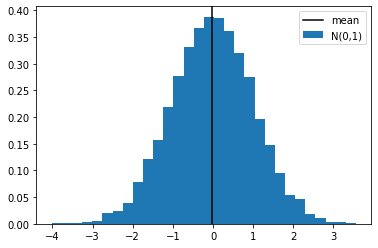

In [27]:
_x1 = np.random.normal(0., 1., size=10000)
_ = plt.hist(_x1, bins=30, density=True, label='N(0,1)')
_ = plt.axvline(np.mean(_x1), c='black', label='mean')
_ = plt.legend()

But look how the mean is barely informative here:

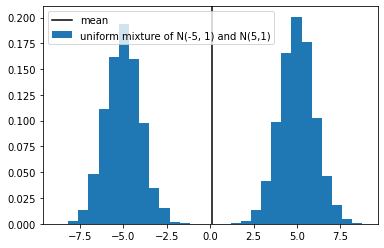

In [28]:
_x2 = np.where(
    np.random.uniform(0., 1., size=10000) > 0.5,
    np.random.normal(5., 1., size=10000),
    np.random.normal(-5., 1., size=10000)
)
_ = plt.hist(_x2, bins=30, density=True, label='uniform mixture of N(-5, 1) and N(5,1)')
_ = plt.axvline(np.mean(_x2), c='black', label='mean')
_ = plt.legend()

And not very informative here: 

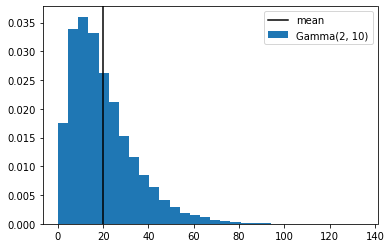

In [29]:
_x3 = np.random.gamma(2., 10., size=10000)
_ = plt.hist(_x3, bins=30, density=True, label='Gamma(2, 10)')
_ = plt.axvline(np.mean(_x3), c='black', label='mean')
_ = plt.legend()

We tend to associate the mean with our intuitions about continuous distributions that are *unimodal* and *symmetric* (also referred to as "bell-shaped" distributions). Not because we should, but simply because those are the distributions we have been more exposed to up until now.


If you don't remember much about unimodality and symmetry, you might want to check the [wikipedia page on the *mode of a distribution*](https://en.wikipedia.org/wiki/Mode_(statistics)).

In this section we will learn about better ways to summarise and visualise data.

## <a name="desc"> Descriptive statistics


We are going to compare the distribution of sentence length (expressed in number of tokens) of `wsj_sample_split.txt` and `twitter_sample.txt`. 

We can start with some simple descriptive statistics of the data. Scipy offers a useful helper function for that `scipy.stats.describe`. 

In [30]:
print(st.describe(wsj_lens))
print(st.describe(twitter_lens))

DescribeResult(nobs=39604, minmax=(1, 141), mean=23.88895061104939, variance=125.62360439328825, skewness=0.7197732760831369, kurtosis=1.3182190777686653)
DescribeResult(nobs=11000, minmax=(1, 73), mean=15.551363636363636, variance=65.06018543008041, skewness=0.3937378711388502, kurtosis=-0.3890335587631375)


Compare to the mean alone, we already gained information about spread (variance) and skewness.

Quantiles (such as the median) can also be useful:

In [31]:
np.median(wsj_lens), np.median(twitter_lens)

(23.0, 15.0)

## <a name="hist"> Histograms

You may have noticed that the datasets are quite different. These descriptive statistics are already a clear enough indication that the differences are many, but sometimes it's insightful to visualise the measurements. This is not always possible, but since for univariate measurements, such as length, we can plot them in a number of different ways. 

A [histogram](https://en.wikipedia.org/wiki/Histogram) can give us an overview of the distribution of univariate data (like our length measurements).

**Exercise with solution** 
    
Plot a histogram (e.g., [using matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)) for each of the two datasets and make remarks about the shapes you see. 

If you are satisfied with your plot, take a moment to study our example solution, you may find some good ideas for future visualisations.


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:
    
```python
    
# Let's plot the two data vectors using histograms, 
#  for better visualisation, we will use two plots and have them share the x-axis
#  we will not be sharing the y-axis because it will be used for counts
#  as the datasets differ in size, the counts are not directly comparable, so sharing the y-axis would
#  give us misleading information
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 3))
# Histograms group data points into bins of a given size, 
#  numpy can help us figure out the bin sizes
#  when we are comparing multiple data vectors, it's a good idea to use all datapoints
#  to determine the bins
bins = np.histogram_bin_edges(np.concatenate([wsj_lens, twitter_lens]), bins='auto')
# We can now plot our histograms
_ = ax[0].hist(wsj_lens, bins=bins)
_ = ax[1].hist(twitter_lens, bins=bins)
_ = ax[0].set_ylabel('Count')
_ = ax[0].set_xlabel('Sentence length on wsj')
_ = ax[1].set_ylabel('Count')
_ = ax[1].set_xlabel('Sentence length on twitter')
_ = fig.tight_layout(w_pad=1, h_pad=1)    
    
```    
    
**Remarks**

* The wsj distribution is somewhat simpler, in that it has a single "hilltop", whereas the twitter distribution shows two hilltops. 
* The wsj distribution also spreads over a wider range, which is expected given that tweets are capped by length (in characters) by design.
* The wsj distribution spreads to the right more than it spreads to the left: symmetry is unlikely for length, because length is capped from below (we cannot observe negative length).

---
    
</details>    


You or may not have noticed, but visualisation techniques have their own parameters, they make their own simplifying assumptions, and they highlight specific aspects of the data. In fact, visualisation techniques are not too different from modelling techniques (which we will learn about in this course).

For example, a histogram is affected by the bins, too thin and we will see "more detail" than there really is in the data (e.g., we may get the impression that a sentence with 10 tokens is far more probable than a sentence with 12 tokens), too wide we will miss existing trends (e.g., we may not notice a second hilltop indicating that many tweets are around 10 tokens long and many tweets are around 25 tokens long). 

If you have not noticed the importance of this parameter, go back to your plot and vary it a bit. Check what happens if you change the bins argument in the previous plot to something like 5, 10, or 100. You should note that with 5 or 10 the distributions appear more similar, while with 100 we see lots of neighbouring peaks in the wsj distribution, which are not really representative of what to expect (i.e., we do not expect the frequency of similar lengths to vary so much). A default histogram is seldom the ideal choice, always experiment with the `bins` parameter, setting it to different values and/or exploiting some of the [special options already coded in numpy](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html). 


## <a name="box"> Boxplot

There are other visualisation strategies. A rather popular one is a [boxplot](https://en.wikipedia.org/wiki/Box_plot) (e.g., [matplotlib implementation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)). While boxplots are useful, they have to be used carefully. 


A boxplot is most suited to visualise *unimodal distributions* (or distributions with a single "hilltop"), that's because a boxplot is built upon statistics like the mean, the median, and other quantiles, which are not very indicative of multimodality.

In [ ]:
_ = plt.boxplot(
    [wsj_lens, twitter_lens],  # one boxplot per collection
    vert=False # plot the boxes horizontally (so the length can be seen on the x-axis)
)
_ = plt.yticks([1, 2], ['wsj', 'twitter'])

See how it's impossible to appreciate the two modes of the distribution for twitter.

While less useful to diagnose multimodality, the boxplot is nice to visualise spread and skewness. If we expect our data to be unimodal, but feel that it may be difficult to prescribe a good strategy for binning, a boxplot may be more adequate.

## <a name="pdsns"> Pandas and searborn tricks

There are other ways to get quick insights from data. 
Pandas, for example, can be very helpful for that. 

Here we construct a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) using our data vectors:

In [ ]:
# The rows in the data frame are the observations, we concatenate all observations available
#  in order to be able to distinguish whether an observation comes from wsj or twitter
#  we 'label' each observation with its source (a string that indicates one corpus or the other)
df = pd.DataFrame(
    [('wsj', x) for x in wsj_lens] 
    + [('twitter', x) for x in twitter_lens], 
    columns=['source', 'length']
)

A DataFrame offers a describe method:

In [ ]:
df.describe()

But this is mixing up both datasets. In order to get a description for each dataset we can use the helper function `groupby':

In [ ]:
df.groupby('source').describe()

Of course, you may write your own code for these kinds of summaries, but knowing these quick tricks can be very handy.

Another example. Now that we have a dataframe, we can get nice histograms from [sns.histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html):

In [ ]:
_ = sns.histplot(
    x='length', # length is what we want to see in the horizontal axis
    hue='source', # we want to separate our measurements as a function of their source
    stat='count', # let's have the number of occurrences of the measurement on the vertical axis
    common_bins=True, # we want the bins to be the same for wsj and twitter
    discrete=True, # the measurements are discrete (this affects the binning strategy)    
    data=df # measurements are stored in this dataframe
)

Seaborn also has [sns.boxplots](https://seaborn.pydata.org/generated/seaborn.boxplot.html):

In [ ]:
_ = sns.boxplot(x='length', y='source', data=df)

And a hybrid of a histogram and a boxplot called violin plot ([wikipedia](https://en.wikipedia.org/wiki/Violin_plot), [sns.violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html)):

In [ ]:
_ = sns.violinplot(x='length', y='source', data=df)

# <a name="analysis"> Analysing properties of corpora
    
Oftentimes, we will be given a collection of data points and we will attempt to extract some patterns from it. 

These patterns can be used to give a compact view of the data, they can be used to extrapolate beyond our observations, they might even be useful in making predictions about future data.

Statistics will be our main tool for text analysis. We will posit a *model of the data*, that is, a probability distribution which we assume was used to generate our data points, and use this model instead of the data directly as a tool for analysis. 

Generally speaking we will

1. Pick a parametric model family. We decide on a type of probability distribution that we think could capture properties of the data that we are interested in (e.g., some distributions can capture properties of continuous measurements, or counts, or categories, etc.).
2. Pick a member of this model family. A probability distribution is typically expressed as a function (sort of a "mathematical law") that relates outcomes and parameters mapping outcomes to probabilities. Once we have chosen a family, we still need to choose the exact member of this family that better approximates properties of our data.

## <a name="len"> Sentence length

For example, a length measurement is an ordinal measurement. The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is one distribution whose support is compatible with our data type. Perhaps this distribution has a member that captures most aspects of our observed data.

Let's draw as many samples from a Poisson distribution as we have sentences in the WSJ corpus and compare them to `wsj_lens` using histograms and violinplots. The Poisson distribution depends on a parameter called *rate* (a strictly positive number that controls the shape of the Poisson probability mass function). Let's compare a few different options (e.g., 10, 20, 30, 100).

<details>
    <summary>How to draw from a Poisson</summary>
    
We can use `np.random.poisson` or `scipy.stats.poisson`. We will be using scipy because it offers more functionality that we will be using later on. In scipy you define a Poisson distribution and then obtain random variates from it:

```python

import scipy.stats as st
st.poisson(10).rvs(5)

```

This obtains 5 draws from the Poisson whose rate parameter is 10.

</details>    

In [ ]:
import scipy.stats as st

_df = pd.DataFrame(
    [('wsj', x) for x in wsj_lens]
    + [('poisson-10', x) for x in st.poisson(10).rvs(len(wsj_lens))]
    + [('poisson-20', x) for x in st.poisson(20).rvs(len(wsj_lens))]
    + [('poisson-30', x) for x in st.poisson(30).rvs(len(wsj_lens))]
    + [('poisson-100', x) for x in st.poisson(100).rvs(len(wsj_lens))],
    columns=['source', 'length']
)
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
_ = sns.histplot(x='length', hue='source', discrete=True, data=_df, ax=ax[0])
_ = sns.violinplot(x='length', y='source', data=_df, ax=ax[1])
fig.tight_layout(w_pad=1, h_pad=1)

We can see that *none* of the Poisson distributions overlaps well with the distribution of data samples. Some options can get the median (the dot of the violinplot), some options will exclude longer sentences, others will only include longer sentences.


Let's assume that there exists a Poisson distribution whose draws look a lot like our data. If that were true, then we would only have to find what is the rate parameter of that Poisson. 

To help us find this rate parameter we need a criterion.

In this course, whenever we need to choose the parameter of a distribution, we will resort to frequentist point estimation. The criterion of choice will be the *likelihood* of the model, and the parameter estimation strategy will be to select the parameter value that has *maximum likelihood* given a dataset of observations.

###Likelihood function

We will now introduce the likelihood function, but before that, we need some notation:

* let $X$ denote a discrete random variable whose outcomes are in a countable set $\mathcal X \subset \mathbb R$
* let $P_X$ denote the probability distribution of $X$, this is denoted $X \sim P_X$;
* let $P_X$ be characterised (i.e., specified) by a parametric *probability mass function* (pmf) $f_\theta: \mathcal X \to [0,1]$ with parameter $\theta$;
    * the probability mass function is used to specify the probability distibution, that is, $P_X(X=x)=f_\theta(x)$ is the probability mass of an outcome $x \in \mathcal X$;
    * by axioms of probability theory, $0 \le f_\theta(x) \le 1$ and $\sum_{x\in \mathcal X}f_\theta(x) = 1$;
* finally, let $\mathcal D = \{x_1, \ldots, x_N\}$ be a dataset of $N$ observed values of $X$.

The **likelihood** of $\theta$ given $\mathcal D$ is defined as:
\begin{align} 
L_{\mathcal{D}}(\theta) &= \prod_{n=1}^{N} P_{X}(X=x_n) = \prod_{n=1}^{N} f_\theta(x_n) ~.
\end{align}

The likelihood function essentially assigns a score to $\theta$ based on three assumptions:
1. each data point $x_n$ is drawn independently of every other data point from the exact same distribution $P_X$, in the literature this is assumption is called i.i.d. for "independent and identically distributed";
2. the distribution from which we draw the data assigns probability $f_\theta(x_n)$ to observation $x_n$;
3. the probability of the dataset under this specific choice of model is informative of the model's ability to generate the observed data.

We will be using the likelihood function to find the value of $\theta$ that is considered optimum (under this definition of optimality). That is:
\begin{equation}
    \theta^{(\text{MLE})} = \arg\max_{\theta }~L_{\mathcal D}(\theta) ~.
\end{equation}

For that purpose, whether we use $L_{\mathcal{D}}(\theta)$ or its logarithm, we will find the same optimum $\theta$ (that's true because logarithm is a monotone function). So we will generally work with the log-likelihood function:
\begin{align} 
\mathcal L_{\mathcal{D}}(\theta) &= \sum_{n=1}^{N} \log f_\theta(x_n) ~,
\end{align}
which is more convenient to manipulate (for example, it's more numerically stable to work with log probabilities in a computer) and search for its optimum:
\begin{equation}
    \theta^{(\text{MLE})} = \arg\max_{\theta }~ \mathcal L_{\mathcal D}(\theta) ~.
\end{equation}



Let's see what log-likelihood can tell us about our choices of Poisson distributions. For that, let's first code the log-likelihood of a choice of Poisson given some data:

<details>
    <summary><b>The Poisson case</b></summary>

The Poisson distribution is characterise by the following probability mass function
\begin{align}
    \mathrm{Poisson}(x|\theta) &= \frac{\theta^x e^{-\theta}}{x!}
\end{align}    
where $\theta \in \mathbb R_{>0}$ is the Poisson *rate*, a strictly positive number. The support of the Poisson distribution is the set of all natural numbers including 0, that is, $x \in \mathbb N_0$. There is no need to memorise the Poisson pmf, if it's ever needed we will give it to you.
       
We use $\mathrm{Poisson}(\theta)$ to denote the entire distribution and $\mathrm{Poisson}(x|\theta)$ to denote the probability mass of a specific outcome $x$ under that distribution.
    
When we write $X \sim \mathrm{Poisson}(\theta)$ we mean: $X$ is a random variable and its probability distribution is $\mathrm{Poisson}(\theta)$.

MLE for the Poisson distribution requires solving the following search problem:
\begin{align}
    \theta^{(\text{MLE})} &= \arg\max_{\theta > 0 }~ \mathcal L_{\mathcal D}(\theta) \\
    &= \arg\max_{\theta > 0 }~\sum_{n=1}^N \log \mathrm{Poisson}(x_n|\theta) \\
    &= \arg\max_{\theta > 0 }~\sum_{n=1}^N \log \frac{\theta^{x_n} e^{-\theta}}{x_n!} ~.
\end{align}
That is, find the strictly positive number $\theta$ that maximises the sum of log probability mass that the distribution $\mathrm{Poisson}(\theta)$ assigns to the observed data points.

---

</details>    

In [ ]:
def poisson_log_likelihood(rate, x):
    """
    Compute the log likelihood of rate given observations x for a model X ~ Poisson(rate).

    rate: the Poisson parameter, a strictly positive scalar 
    x: a data vector containing N observations

    Return a single scalar value: \sum_{n=1}^N \log Poisson(x_n|rate) 
    """
    assert rate > 0., "The Poisson rate must be strictly positive"
    # the rate parameter uniquely identifies a Poisson distribution
    # and scipy gives us action to its probability mass function
    poisson_pmf = st.poisson(rate)  
    # which can be used to compute the log probability mass of the observations     
    loglikelihood = poisson_pmf.logpmf(x)
    # of course, we could have implemented the formulate ourselves (see 'The Poisson case' above)
    # but it's just so much better to rely on stable and standard implementations (like the one in scipy)

    # we return the sum of those log probabilities
    return loglikelihood.sum()

In [ ]:
# These are the rates of the Poisson distributions we considered previously
rates = np.array([10., 20., 30., 100.])
# and these are the log-likelihoods that each rate value gets
lls = [poisson_log_likelihood(rate, wsj_lens) for rate in rates]
_ = plt.plot(rates, lls, '.', label=r'Poisson($\theta$)')
argmax = np.argmax(lls)
best_rate = rates[argmax]
_ = plt.axvline(best_rate, c='r', label=f'Best rate: {best_rate:.2f}')
_ = plt.ylabel(r'$\mathcal{L}_x(\theta)$')
_ = plt.xlabel(r'Rate ($\theta$)')
_ = plt.legend()

We can see that as far as likelihood is concerned, Poisson(20) is the best of the 4 Poisson distributions we tried.

**Computational complexity of likelihood assessment**

**Exercise with solution** If computing the log probability of one observation takes 1 unit of time, which we denote $\mathcal O(1)$, what is the computational complexity of assessing the likelihood function for a dataset of $N$ observations?

<details>
<summary><b>Click for the solution</b></summary>

Assessing the log-likelihood of $\theta$ takes computing the log probability of each and every one of our observations in $\mathcal D$. If computing the log probability of one data point takes one unit of time, then computing the log likelihood of $\theta$ takes $N$ units of time. In big-O notation, we would say the time complexity of computing $\mathcal L_{\mathcal D}(\theta)$ is $\mathcal O(N)$, where $N = |\mathcal D|$.

---

</details>

What if we tried more rate values? 

<a name="ex-poisson-grid"> **Graded exercise - Grid search MLE for Poisson** 
    
Plot the log-llikelihood of various Poisson distributions and determine the one with maximum likelihood given the WSJ data. Repeat the experiment using Twitter data. Use the following options of rate:

```python
rates = np.linspace(1., 100, 1000)
```


You should have found that a rate value close to 24 for WSJ and close to 15.5 for Twitter give you Poisson distributions that attain maximum likelihood in those datasets.

<details>
    <summary>Note on terminology</summary> 
    
In recent years it is becoming more and more common to find papers that refer to $\mathcal L_{\mathcal D}(\theta)$ as the (log-)likelihood of the data. Although widespread, this is a poor use of the word likelihood. The [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function) is a function of the parameter given a fixed dataset. So, $P_{X|\Theta}(X=x|\theta)$ is *not* the likelihood of $x$ given $\theta$. You can either say it is i) the probability of an outcome $X=x$ given a choice of $\theta$, or you can say it is ii) the likelihood of $\theta$ given a fixed data point $x$. Whether to use (i) or (ii) depends on what we are fixing: in parameter estimation the data are fixed, so (ii) is preferred; after estimating $\theta$ we will sometimes use the distribution $P_{X|\Theta=\theta}$ to make predictions, in such contexts we might prefer (i). The term likelihood was introduced to contrast the quantity $P_{X|\Theta}(x|\theta)$ with the quantity $P_{\Theta|X}(\theta|x)$, which is the *posterior* probability of $\theta$ after observing $x$ (a quantity that appears in a Bayesian approach to statistics, along with another famous quantity, the prior probability $P_\Theta(\theta)$ of $\theta$). 

---
    
</details>

### Grid search

The procedure we just used above is called *grid search*. We just choose a grid of values for the parameter of interest, assess the log-likelihood function at each one of the values in this grid, and then pick the value associated with the highest log-likelihood in the grid.

**Computational complexity of grid search**

**Exercise with solution** If computing the log probability of one observation takes 1 unit of time, which we denote $\mathcal O(1)$, what is the computational complexity of grid searching for a parameter with highest likelihood when our dataset contains $N$ observations? 

<details>
<summary><b>Click for the solution</b></summary>

If a grid contains $G$ values in it, then the overall search will take $G\times N$ units of time (because for each parameter value in the grid, we need to assess the log-likelihood of the parameter, which takes $N$ units of time), in big-O notation this is $\mathcal O(G\times N)$.

---

</details>



### Exact MLE for Poisson

Occasionally, we have a simple way to find the exact MLE solution for a given model family, and the Poisson family is one such family, using a simple formula.

It can be shown via differential calculus that the MLE solution for a Poisson family is the rate:
\begin{equation}
    \theta^{(\text{MLE})} = \frac{\sum_{n=1}^N x_n}{N}
\end{equation}
where $\mathcal D = \{x_1, \ldots, x_N\}$ are $N$ observations.


<details>
       <summary>Theory</summary>
    
The Poisson log-likelihood function is what we call a concanve function, or, equivalently, its negative is what we call a convex funciton. A concave function has a single global maximum, or, equivalently, a convex function has a single global minimum. 
    
When that happens we can use derivatives to find the global optimum. A derivative is the slope of a tangent line touching the log-likelihood function at exactly one point (a value of $\theta$), as we vary $\theta$ this slope will vary. At one point, and exactly one point, the tangent line will be parallel to the x-axis (in the case where we have a single parameter), or, more generally, the derivate will be $0$ (or $\mathbf 0$ in a multiparameter case). 
    
If we look for the value $\theta > 0$ for which the derivative of the Poisson log-likelihood is 0, i.e.,  $\frac{\mathrm{d}}{\mathrm{d}\theta} \mathcal L_{\mathcal D}(\theta) = 0$ with $\mathrm{Poisson}(\theta)$ as a model of the observed data $\mathcal D$, we will find the expression $ \theta^{(\text{MLE})} = \frac{\sum_{n=1}^N x_n}{N}$.
  
---

</details>    

<a name="ex-poisson-mle"> **Graded exercise - Exact MLE for Poisson** 
    
For each dataset (i.e., WSJ and Twitter) separately, 1) compute the MLE for a Poisson model of the data, 2) plot samples from the MLE Poisson model against the observations (use as many samples as you have observations in each dataset, use plots such as histograms and violinplots), and 3) make remarks about the model's ability to reproduce the data (discuss aspects such the ability of matching the mean, the variance, the skewness, the mode(s)).

**Exercise with solution** Comment on the differences in computational complexity between grid search and the exact MLE for a Poisson length model.

<details>
  <summary><b>Click for a solution</b></summary>


For a dataset of size $N$, exact MLE takes $N$ units of time: because to average the measurements and obtain the MLE solution we need to iterate over the $N$ observations.

Assuming that assessing the probability of one observation takes 1 unit of time, grid search requires $N$ units of time per parameter value in the grid: because for each parameter value in the grid we need to assess the probability of each and every observation under the corresponding Poisson. 

If our grid has $G$ parameter values in it, grid search will take $G\times N$ units of time, which is a lot more than the exact solution.

Essentially, if we have an exact formula, there's no need for a search, we arrive at the exact solution by simply computing a statistic of the dataset (in this case, the sample mean).

---

</details>

The Poisson distribution is not the only distribution compatible with our data type, another distribution that supports natural numbers is the [Geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution) (available on scipy as `scipy.stats.geom`). As a candidate model of our datasets, Geometric distributions are worse than Poisson distributions. After you are done with this lab, we suggest you get back to this part and try to compare Geometric models to Poisson models for the length data.

In this tutorial we will not attempt to improve upon the Poisson model yet.

**Compactness** Note that once we have chosen a parametric family (e.g., Poisson) and estimated its parameter (e.g., rate) from data, that's all we need to store. The idea is that knowing $\mathrm{Poisson}(\lambda)$ is as good as having access to the whole dataset, and potentially better, since the pmf of the Poisson can tell us whether / how often to expect values of length that we have not observed.

Of course, this assumption will depend on how well the parametric model reproduces patterns that do occur in the data.

## <a name="rankfreq"> Rank-Frequency


Natural languages are remarkably productive, an human speakers are very creative. Day after day, the vocabulary of every natural language actively spoken on the planet is continuously changing. New words are created, existing words are reused in novel ways, some words lose their prominence.

In most NLP applications the vocabulary of a language is frozen. We consider a "vocabulary" the set of all known types at a given time. Here we use the word *type* to distinguish, for example, the unique token `the` from its many occurrences in a corpus, which we usually call *instances*).

Entries in a vocabulary are generally referred to as *words*, but in NLP they really are *tokens*, where a *token* is whatever sequence of characters that we treat as a unit (typically a sequence of non-blank characters). For example, linguistically speaking `Oct.` is not a word (it's an abbreviated form of the word `October`), but it may well be a token in our NLP system's vocabulary. Conversely, `camera-ready` is a word in English, but any one occurrence of `camera-ready` may be split into one or more tokens depending on our tokenization strategy (e.g., `camera`, `-`, `ready`). Moreover, while linguistically `Oct.` really is an instance of the word `October`, unless we are explicit about it, a computer cannot tell that. NLP systems won't be able to infer the relationship between these two strings, `Oct.` and `October`, unless we give them the means to do so. 

We will now begin to appreciate one of the most important aspects of written language: *data sparsity*. Data sparsity affects many aspects of NLP systems, and a system's vocabulary is probably the best example.

You are probably aware of [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), an empirical finding that the frequency of any word is inversely proportional to its rank in the frequency table. We will now verify this finding. 

**Data** NLTK also provides access to corpora. 

You can check the documentation of the [corpus package](https://www.nltk.org/api/nltk.corpus.html#module-nltk.corpus) online or on your own jupyter notebook using `nltk.corpus?`. Here is a [list of available corpora](http://www.nltk.org/nltk_data/).

Corpora in NLTK are mostly already pre-processed at the basic levels (e.g., sentence splitting, and tokenization). 

Let's have a look at sample from the English PeenTreebank (again, a section of the WSJ corpus). If you are a Dutch speaker, you can also check Alpino (Dutch). 

In [ ]:
from nltk.corpus import floresta as pt_floresta
from nltk.corpus import alpino as nl_alpino
from nltk.corpus import treebank as en_ptb

In [ ]:
len(en_ptb.words()), len(nl_alpino.words()), len(pt_floresta.words())

To work with rank and frequency we need to determine the number of occurrences of each token in the vocabulary of a given corpus. In python, a `Counter` (from `collections`) can help us achieve that (if you are not familiar with `Counter` but know `dict`, they are very similar, check the python docs).

In [ ]:
from collections import Counter

In [ ]:
counter = Counter(en_ptb.words())

The counter stores a dictionary where each key is an observed token and its value is the number of times it occurred.

In [ ]:
# Note that we can use the counter as a dictionary that maps from a token to its count:
'day' in counter.keys(), counter['day']

In [ ]:
'NTMI' in counter.keys()  # it looks like our course has not been mentioned in the Penn Treebank yet ;)

Counters can sort the vocabulary for us:

In [ ]:
counter.most_common(10)

Unfortunately, computers do not know that tokens like 'Day' and 'day' refer to the same thing.

In [ ]:
# Note that for a computer 'Day' and 'day' are different tokens.
'Day' in counter.keys(), counter['Day']

**Exercise with solution** One way to deal with that is to lowercase the data as a pre-processing step. This has downsides, can you think of some?

<details>
    <summary> <b>Click for a solution</b>  </summary>

Not every language uses lower/upper case characters (e.g., Chinese, Japanese, Arabic).

---
    
</details>    

This is not the only issue contributing to sparse vocabularies. Morhopological inflection does that too, for example, singular vs plural, gender marking, syntactic case, all these linguistic devices contribute to data sparsity, and in some applications we might want to treat all instances of `day`, `Day`, `days`, and `Days` as if they referred to the same type (the English word `DAY`).

One relatively simple way to reduce the vocabulary size by collapsing different variants of a certain base form is to use a [stemmer](https://en.wikipedia.org/wiki/Stemming). NLTK provides options for a few languages including [English, Dutch, and Portuguese](https://www.nltk.org/api/nltk.stem.html). 

Here is an example of what stemmers do:

In [ ]:
from nltk.stem.snowball import EnglishStemmer, DutchStemmer, PortugueseStemmer

In [ ]:
en_stemmer = EnglishStemmer()
nl_stemmer = DutchStemmer()
pt_stemmer = PortugueseStemmer()

In [ ]:
from tabulate import tabulate

for i, s in zip(range(3), en_ptb.sents()):
    rows = []
    rows.extend([(w, en_stemmer.stem(w)) for w in s])
    print(tabulate(rows, headers=['word', 'stem']))
    print()

Here's some helper code to map from tokens to ranks and/or rank-frequency pairs:

**Exercise with solution** 
    
Use a loglog plot to verify Zipf's law (i.e., if you plot the log of the rank vs the log of the frequency, you should see something close to a straight line). Verify this is the case for `en_ptb`, `nl_alpino` and `pt_floresta`, and make sure to stem the corpora before analysing it. Make some remarks trying to interpret the information in the plot (i.e., the relationship between rank and frequency in corpora).

Note that `en_ptb.words()` is already sentence split and tokenized, and the same is true for the other two corpora.

We have made a few helper functions available for you, see them below.

In [ ]:
def get_ranks(words):
    """Map a list of words to a np.array of ranks, where the most frequent word is assigned rank 1"""
    counter = Counter(words)
    w2r = {word: rank for rank, (word, count) in enumerate(counter.most_common(), 1)}
    return np.array([w2r[w] for w in words])

def get_rankfreq_pairs(words):
    """
    Map a list of words to an np.array with shape [K, 2] where K is the number of distinct tokens in the input list.
    The first column of the array is the rank, the second column of the array is the count.
    """
    counter = Counter(words)
    # rank-frequency
    rf = np.array([[r, n] for r, (w, n) in enumerate(counter.most_common(), 1)])
    return rf

<details>
    <summary><b> Click for a solution </b></summary>
    
```python
from itertools import cycle
palette = cycle(sns.color_palette())

for corpus_name, corpus, stemmer in zip(['en_ptb', 'nl_alpino', 'pt_floresta'], [en_ptb, nl_alpino, pt_floresta], [en_stemmer, nl_stemmer, pt_stemmer]):

    words = corpus.words()
    rf = get_rankfreq_pairs((stemmer.stem(w) for w in words)) # I'll be lowercasing the words, since it makes sense for these languages   
    c = next(palette)
    _ = plt.loglog(rf[:,0], rf[:,1], '-', c=c, label=corpus_name)
_ = plt.legend()    
```    


The general tendency indeed looks like a straight line, which in a log-log plot denotes an exponential relationship between rank and frequency, as the line has a negative angle (with the x-axis) we can conclude that frequency decays exponentially fast with an increase in rank. That's the second most frequent word is exponentially less frequent than the first, and so on. 

The lines are not very straight at the extremes (lowest and highest ranks). The lowest ranks are probably distorted because of the presence of stop words. As for the highest rank, the information is probably distorted because of dataset size. Generally, it does look like Zipf's law is indeed a robust finding.

---
    
</details>

### Zipf and Zeta 

We will now design a statistical model of the rank. For that, we can use the [Zipf distribution](https://en.wikipedia.org/wiki/Zipf's_law) which predicts  that out of a population of $N > 0$ elements, the probability of the element of rank $k \ge 1$ is 
\begin{align}
\mathrm{Zipf}(k|N, s) = \frac{\frac{1}{k^s}}{H_{N,s}}
\end{align}
where the normalisation terms is defined as $H_{N,s} = \sum_{n=1}^N \frac{1}{k^s}$, and $s>1$ is called the *power parameter*.

The Zipf distribution requires a fixed number of draws $N$ and thus supports ranks in $\{1, \ldots, N\}$.

A slightly more convenient option is the [Zeta distribution](https://en.wikipedia.org/wiki/Zeta_distribution) which generalises the Zipf distribution removing the need to specify the total number of elements in the population. This is convenient when we are analysing populations (corpora) of different size.

The Zeta distribution assigns probability 
\begin{align}
\mathrm{Zeta}(k|s) = \frac{\frac{1}{k^s}}{\zeta(s)}
\end{align}
to rank $X=k$. The power parameter is $s>1$ as before, and $\zeta(s) = \sum_{n=1}^{\infty} \frac{1}{n^s}$ is the [Riemann zeta function](https://en.wikipedia.org/wiki/Riemann_zeta_function) which is implemented in `scipy.special.zeta`. The support of the Zeta distribution is $\mathbb N_1 = \{1, 2, \ldots\}$.

<a name="ex-zeta-grid"> **Graded exercise - Grid search MLE for Zeta** 
    
Perform a grid search to estimate the power parameter of the Zeta distribution for each dataset. Note that power parameters must be greater than 1. A reasonable range of parameters to test is something like `[1.01, 3.0]`. Obtain samples from the MLE Zeta and plot them against the observations (use as many samples as you have observations). Comment on the fit: do you think the model fits the data well, does it fit the data well for most rank values or are there types of values (eg, very low, or very high) for which the model does not do so well?

As scipy has a stable implementation of the Riemann zeta function `scipy.special.zeta`, we could implement the pmf of the Zeta distribution yourselves. Generally, however, it is always a good idea to reuse high quality mathematical code. It turns out, the statistics package in scipy has a stable implementation of the Zeta distribution, but, funnily enough, it is named `scipy.stats.zipf`, instead of `scipy.stats.zeta`. For some historical accident, the two terms 'Zipf distribution' and 'Zeta distribution' came to be used somewhat interchangeably in statistics. In doubt, see that if it takes two parameters (total population size $N > 1$ and power $s > 1$) we have the classic Zipf, if it takes one parameter (just the power $s>1$), we have Zipf's generalisation called Zeta.


In any case, we will go on with the *Zeta* distribution, you can count on its good implementation from scipy which is called `scipy.stats.zipf`.


<details>
 <summary> Hint </summary>

Check the grid search we did for the Poisson case, we first implemented the Poisson likelihood function, and then implemented the search. The strategy here is very similar, but watch out that you use the correct pmf.

---

</details>

<details>
 <summary> You do not need to use this trick, but you may find it useful. </summary>

Check the grid search we did for the Poisson case, we first implemented the Poisson likelihood function, and then implemented the search. The strategy here is very similar, but watch out that you use the correct pmf.

For discrete data, sometimes we store the *counts* of the outcomes rather than the outcomes themselves, that is, we store a vector $\mathbf c$ where $0 \le c_k \le N$ is the number of times outcome $k$ occurs in $\mathcal D$. We can re-express the log-likelihood function in terms of counts:

\begin{align} 
\mathcal L_{\mathcal{D}}(\theta) &= \sum_{n=1}^N \log f_\theta(x_n) = \sum_{k \in \mathrm{supp}(P_X)} c_k \log f_\theta(k) ~,
\end{align}

where in practice we only evaluate the terms for which $c_k > 0$ in the dataset.

</details>

## <a name="categories"> Categories

The length of a sentecen is a observable statistic of a data point (e.g., the sentence `what a nice day` has lenght 4). An overall law of length for a corpus is not something we can observe directly, rather, we posit one (e.g., a Poisson law) and we can find the parameter that gives us the best instance of this law under the maximum likelihood criterion. The power-law that governs a corpus is also unobservable, but we can posit one power-law (e.g., Zipf's law) and estimate the power parameter from data.

Sometimes, we want to analyse text in terms of observable attributes of the data that are not as trivial to obtain as length, rather, attributes that require an annotation process. 

For example, users of websites like Amazon.com and Bol.com often contribute reviews to products they buy. As a reviewer you contribute a lot of valuable information about the product, which is normally accompanied by some textual data. 

We've downloaded a small dataset of reviews for musical instruments (data obtained from [here](https://jmcauley.ucsd.edu/data/amazon/)) which will help us illustrate some concepts.

In [ ]:
reviews = download_corpus(
    "https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/Musical_Instruments_5.json.gz",
    is_gz=True,
    json_lines=True
)
len(reviews)

Let's begin by simply inspecting what a data record looks like:

In [ ]:
for record in reviews:
  if record['overall'] == 2:
    print(record)
    print(record['reviewText'])
    print(record['helpful'])
    print(record['overall'])
    print(record['summary'])
    break

We have 
* a unique identifier for the reviewer (reviewerID)
* a unique identified for the product (asin)
* a review (reviewText)
* a summary of the review (summary)
* an overall score from 1 star (worst) to 5 stars (best).

amongst other things. 

Let's create a pandas dataframe with the attributes we are interested in, as well as two additional attributes (review length and length of summary):

In [ ]:
reviews_df = pd.DataFrame(
    data=[
        (record['asin'], 
         record['reviewerID'], 
         record['summary'].lower(), 
         len(record['summary'].lower().split()),  # we will be a bit naive about normalisation in this part
         record['reviewText'], 
         len(record['reviewText'].split()), # we will be a bit naive about normalisation in this part
         record['overall']
        )
        for record in reviews
    ],
    columns=['product', 'reviewer', 'summary', 'summary-len', 'review', 'review-len', 'score']
)

Let's have pandas share some quick summaries with us:

In [ ]:
_ = reviews_df.hist()

See that most summaries are under 20 words long, reviews can be quite long, and this dataset is skewed towards products that received good reviews. 

Let's have a look at the most popular products:

In [ ]:
prod_counter = Counter(reviews_df['product'])
top10_prods = prod_counter.most_common(10)
top10_prods

In [ ]:
reviews_df[reviews_df['product'] == top10_prods[0][0]][:5] # only displaying the first 5 records for this top product

The most active reviewers:

In [ ]:
reviewer_counter = Counter(reviews_df['reviewer'])
top10_reviewers = reviewer_counter.most_common(10)
top10_reviewers

In [ ]:
reviews_df[reviews_df['reviewer'] == top10_reviewers[0][0]][:5] # only displaying the first 5 records for the top reviewer

In [ ]:
summary_counter = Counter(reviews_df['summary'])
top10_summaries = summary_counter.most_common(10)
top10_summaries

In [ ]:
reviews_df[reviews_df['summary'] == top10_summaries[0][0]][:5] # only displaying the first 5 records for the most common summary

In [ ]:
reviews_df[reviews_df['summary'] == top10_summaries[1][0]][:5] # only displaying the first 5 records for the second most common summary

Note that *reviews* are often rather long, and that makes them very unlikely to repeat (the only review that appears multiple times is the useless empty review):

In [ ]:
Counter(reviews_df['review']).most_common(5)

### Plotting marginally

We can plot the scores assigned to products marginally (that is, regardless of any other information). 

In [ ]:
_ = reviews_df['score'].hist()

Marignal plots can tell us something about the entire dataset. For example, that this dataset is skewed towards good products (or products that were assigned high scores).

This is much like the plots we had for sentence length. The difference here is the data type: this time we have finitely many possible values (i.e., 1, 2, 3, 4, 5). 


### Estimating Categorical distributions

Luckily, statistics and probability give us powerful tools to represent and manipulating uncertainty.

We can store the uncertainty in this plot in a probability distribution, much like we did for length. As before, we will pick a parametric probability distribution and estimate its parameters as to best fit our observations.

This time, we will pick the [Categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution).

The Categorical distribution over $C$ categories $\{1, \ldots, C\}$, which we denote $\mathrm{Cat}(\theta_1, \ldots, \theta_C)$, assigns probability mass

\begin{equation}
\mathrm{Cat}(x|\theta_1, \ldots, \theta_C) = \theta_x ~.
\end{equation}

<details>
<summary> Iverson bracket </summary>
    
The Iverson bracket $[\alpha]$ is the mathematical way to convert the result of a boolean expression to $0$ or $1$. If the boolean expression $\alpha$ inside the brackets evaluates to True, then this operator returns $1$, otherwise it returns $0$.
    
Examples: $[1 > 0]$ returns 1, $[\text{cat} \in \{\text{cat}, \text{dog}\}]$ returns 1, $[3 = 2]$ returns 0.
    
With the Iverson bracket we can express the Categorical pmf as:
    
\begin{equation}
\mathrm{Cat}(x|\theta_{1:C}) = \prod_{c=1}^C \theta_c^{[x=c]} ~.
\end{equation}
    
Take a moment to see that this evaluates to exactly $\theta_x$. This notation is common in some technical papers, and, though we will mostly only rely on the simpler notation $\theta_x$, it's useful to be able to understand this notation should you come across it.
    
---
    
</details>    


The Categorical pmf takes $C$ parameters, denoted $\theta_1, \ldots, \theta_C$, each such parameter is a probability value (i.e., $0 \le \theta_c \le 1$) and the sum of all parameters is $1$ (i.e., $\sum_{c=1}^C\theta_c = 1$).
Sometimes instead of writing $\theta_1, \ldots, \theta_C$ we use the shorter version  $\theta_{1:C}$ or even vector notation: $\boldsymbol \theta = (\theta_1, \ldots, \theta_C)^\top$. In this course, as in most courses, a vector is a column vector. Because we can think of the $C$ parameters as forming a vector, we often call $\boldsymbol \theta$ the *Categorical parameter* (where we use the singular form as in "parameter vector"). 


<details>
<summary> Probability simplex </summary>
    
A compact way of conveying the fact that "$\boldsymbol \theta$ is a $C$-dimensional vector whose coordinates are positive and sum to 1" is to write: $\boldsymbol \theta \in \Delta_{C-1}$, which is pronounced "theta is a vector in the C-minus-one-dimensional simplex".

The space of all vectors of length $C$ that are constrained to being valid probability vectors is called the *probability simplex*, and it's denoted $\Delta_{C-1}$. The reason for the symbol $\Delta$ is that for $3$ classes, the space looks like a triangle. The reason for using $C-1$ in the subscript, rather than $C$, is that the simplex for 3-dimensional probability vectors is a 2-dimensional surface inside of the 3-dimensional real coordinate space. This [Wikipedia page](https://en.wikipedia.org/wiki/Simplex) has some illustrations.
    
Yet another way is to write $\boldsymbol \theta \in \mathbb R_{\ge 0}^C$ and $\boldsymbol \theta^\top \mathbf 1 = 1$. That is, $\boldsymbol \theta$ is a vector of $C$ positive coordinates (because it lives in $\mathbb R_{\ge 0}^C$) and they sum to 1 (because the dot-product of $\boldsymbol \theta$ with the C-dimensional vector of 1s is 1).    
    
---
    
</details>    

**Exact MLE** 

MLE for the categorical distribution is not simple to do via grid search. That's for two reasons: a) the categorical parameter is C-dimensional (so if we were to try $m$ values for each parameter, there would be $m^C$ possible combinations!), b) the categorical parameter is constrained in a special way (it must live in the simplex, thus we would have to be able to efficiently enumerate a grid of simplex-constrained parameters only). 

Fortunately, we will never have to use grid search for the Categorical distribution.

If we have a Categorical random variable $X \sim \mathrm{Cat}(\theta_{1}, \ldots, \theta_C)$ and a dataset $\mathcal D = \{x_1, \ldots, x_N\}$ of observations, such that $x_n \in \{1, \ldots, C\}$. It can be shown, via differential calculus, that the MLE of the Categorical distribution is given by 
\begin{equation}
\theta_c = \frac{\sum_{n=1}^N [x_n = c]}{N} ~.
\end{equation}

Take a moment to understand the notation in the numerator. Can you see that it essentially means "the number of times $X=c$ can be observed in the dataset? 
    
In fact, if we define an auxiliary function $\mathrm{count}_X(c)$ which returns the number of occurrences of $X=c$ in the dataset $\mathcal D$, then we can express the MLE as: $ \theta_c = \frac{\mathrm{count}_X(c)}{N}$. In this course, when asked for an expression for the MLE of the Categorical parameter, it is fine to use the count-type notation instead of the form with the Iverson bracket,  as long as you explain what the count function does. Still, you should be able to at least recognise and understand the more formal notation if you see it in the material, in exercises, or in the exam.

**Exercise with solution** 
    
Assume the marginal distribution of scores is Categorical, compute its maximum likelihood parameter. Draw samples from the resulting Categorical distribution and plot them against the observations (draw as many samples as you have observations).

Scipy does not offer a Categorical distribution (instead it offers the closely-related Multinomial distribution), but to keep the implementation very similar to the theory, we provide you with an implementation of a Categorical distribution below.

In [ ]:
class Categorical:
    
    def __init__(self, probs):
        self._probs = np.array(probs)
        assert np.all(self._probs >= 0), "The coordinates of the Categorical parameter must be positve"
        assert self._probs.sum() == 1, "The coordinates of the Categorical parameter must add to 1"
        
    def rvs(self, size=None):
        """Use this to draw 1 or more samples from the distribution"""
        # we shift by one because random.choice returns 0-based outcomes
        return np.random.choice(len(self._probs), p=self._probs, size=size) + 1

    def pmf(self, x):        
        """Use this to assess the probability mass of the elements of a data vector"""
        x = np.array(x, dtype=int) - 1 # convert to 0-based
        return self._probs[x]
    
    def logpmf(self, x):
        """Use this to assess the logarithm of the probability mass of the elements of a data vector"""
        x = np.array(x, dtype=int) - 1 # covert to 0-based
        return np.log(self._probs[x])
    
assert all(Categorical(np.ones(5)/5).pmf(1) for c in range(1, 6)), "The uniform distribution over 5 classes should assign probability 1/5 to all of its outcomes"
assert Categorical(np.ones(5)/5).pmf(np.arange(1, 6)).sum() == 1., "The distribution should sum to 1"

<details>
    <summary><b> Click for a solution </b></summary>

```python
    
def categorical_MLE(x, num_classes):
    """
    x: a sequence of observations, each a class in {1, ..., num_classes}.
    num_classes: the number of known categories

    Return a vector containing num_classes probabilities that sum to 1 and are the MLE solution given x.
    """
    assert num_classes > 1, "We need at least 2 classes"
    N = len(x)    
    assert N > 0, "We need at least one observation"
    counts = Counter(x)    
    probs = np.array([counts.get(c, 0) / N for c in range(1, num_classes + 1)])
    return probs

# Find the MLE solution
score_MLE = categorical_MLE(reviews_df['score'], 5)
# Draw samples
x_ = Categorical(score_MLE).rvs(len(reviews_df['score']))
# Plot samples against observations
_ = pd.DataFrame(
    [('obs', record['overall']) for record in reviews] 
    + [('MLE', score) for score in x_],
    columns=['source', 'score']
).groupby('source').hist()   
    
```    
    
---
    
</details>    

Note that unlike what happened with the Poisson model of length, the Categorical model of scores matches the data *very well*. This is not surprising: the Poisson model of length has a single parameter (the rate) to model the entire collection, the Categorical model of scores has a parameter per score, each such parameter can capture the exact marginal frequency of the class.

This is not surprising and this is not as exciting as it sounds, as we will see in the what follows.

### Plotting conditionally

We can also partition the observations as a function of some conditioning variable or *covariate*. For example, we can partition the dataset as a function of product ID, we could then potentially obtain one plot per product ID.


**Exercise with solution** Can you think of any caveats of plotting the data conditionally like that?

<details>
    <summary> <b> Click for a solution </b> </summary>
    
Some products may have received very few reviews, perhaps only one, the less reviews we have for a product, the less information we can reliably obtain from our plots. When we partition the data like that we effectively obtain smaller datasets, one per value of the conditioning variable.

---
    
</details>    

Let's use seaborn to barplot the frequency/count of score as a function of product id. As there are many products we will plot only the 10 most reviewed products:

In [ ]:
_ = sns.catplot(
    y='product',  # we want to see products on the y-axis
    kind='count', # counts on the x-axis
    hue='score',  # we want to count scores
    data=reviews_df[reviews_df['product'].isin(set(pair[0] for pair in top10_prods))]  # we want reviews for products in the top10 most reviewed products
)

This plot clearly shows that the people's opinions on a given product can vary considerably. This is expected, after all, opinions are informed by the quality of a product but ultimately are subjective measurements.

Still, there's value in knowing what range of scores a given product typically receives. In fact, there's more value in having a view of the distribution of scores associated with each product than only knowing the average score (the mean), or the most common score (the mode), since these single-number summaries might hide information such as spread and skew of scores, or the fact that scores concentrate in two different sides of the spectrum (e.g., products that are loved by about half the people, but also hated by about half the people).

Let's use seaborn to get barplots of score as a function of reviewer identity. As there are many reviewers we will plot only the 10 most active reviewers:

In [ ]:
_ = sns.catplot(
    y='reviewer',  # we want to see reviewers on the y-axis
    kind='count', # counts on the x-axis
    hue='score',  # we want to count scores
    data=reviews_df[reviews_df['reviewer'].isin(set(pair[0] for pair in top10_reviewers))]  # we want reviews for products reviewed by the top10 most active reviewers
)

This plot shows that the top10 reviewers are rather generally more positive than otherwise.

In some situations, it might be useful to know the distribution of scores a certain reviewer assigns. This could be used, for example, to spot reviewers that are not very discriminative (they like everything consistently, or dislike everything consistently). 

**Conditioning on text** 

Note that while the relationship between length and a sentence is deterministic (i.e., given a tokenization algorithm, we know the lengt), the relationship between a product review (expressed in text) and the reviewer's opinion (expressed in stars) is not. 

You can imagine that the same person might assign score 3 to a product in one day, and perhaps in a different day assign it score 2. If you show the review text to 10 different people, and ask them to guess the score the user would have assigned, you will likely obtain more than 1 answer, again showing that the mapping from review text to star-rating is non-deterministic. This often happens even if you ask the same person in different occasions.

Here we plot the score conditioned on the summary of the review for a few of the most common summaries:

In [ ]:
_ = sns.catplot(    
    y='summary',
    kind='count',
    hue='score',
    data=reviews_df[reviews_df['summary'].isin(set(pair[0] for pair in summary_counter.most_common(20)))],
)

Here we see that *even* once we are given the summary, there is still some uncertainty left. That is, in terms of stars, even a summary like "perfect" or "does the job" might still mean different things for different people.

### Estimating conditional Categorical distributions

In some cases we will assume that a random variable $X$ is Categorically-distributed *given* some other information, which we denote $X |S =s \sim \mathrm{Cat}(\theta^{(s)}_1, \ldots, \theta^{(s)}_C)$.

Let's digest this:

* we have a categorical random variable $X$ with outcomes in the set from 1 to $C$ ;
* given a value $s$ of some other variable $S$, we obtain a parameter vector $\boldsymbol\theta^{(s)} = (\theta^{(s)}_1, \ldots, \theta^{(s)}_C)^\top$, this parameter vector specifies a Categorical distribution for $X$ which is *specific* to the situation where $S=s$. 

You can visualise the collection of parameters that specify our conditional Categorical distributions as a table. Each value $S=s$ indexes a row of this table, the cells in the row are the coordinates of the probability vector associated with $s$ (so we must have $C$ columns in the table). Because you can visualise it as a table, we call this a *tabular representation*.  

For example: suppose $S$ is a review summary and $X$ is the review score, 

| $S$          | $\theta^{(s)}_1$ | $\theta^{(s)}_2$ | $\theta^{(s)}_3$ | $\theta^{(s)}_4$ | $\theta^{(s)}_5$ |
|--------------|------------------|------------------|------------------|------------------|------------------|
| good         | 0.               | 0.1              | 0.2              | 0.5              | 0.2              |
| great value  | 0.               | 0.               | 0.2              | 0.3              | 0.5              |
| does the job | 0.1              | 0.2              | 0.3              | 0.3              | 0.1              |
| ...          |                  |                  |                  |                  |                  |

* when $S=\text{good}$, we obtain a parameter vector specific to that summary, for example, that vector might be $\boldsymbol \theta^{(\text{good})} = (0., 0.1, 0.2, 0.5, 0.2)^\top$;
* when $S=\text{does the job}$, we obtain a parameter vector specific to that summary, for example, that vector might be $\boldsymbol \theta^{(\text{does the job})} = (0.1, 0.2, 0.3, 0.3, 0.1)^\top$.

In each context, that's given a specific summary, we have a Categorical distribution from where we can sample review scores.


**Exercise with solution** If we have $K$ dinstinct summaries in a dataset, how many Categorical distributions do we have to estimate in order to model scores conditionally given the summary? How many *parameters* do we need to estimate in total? 

<details>
    <summary> <b> Click for the solution</b> </summary>
    
For this model definition, we need to estimate one Categorical distribution per summary, thus if we have $K$ summaries in the data, we need $K$ Categorical distributions.
    
Each distribution is defined over $C$ classes (C is 5 in this dataset), and thus requires $C$ probability values. In total, we will need to estimate $K \times C$ parameters.

---    
    
</details>    


<a name="ex-cpds"> **Graded Exercise - MLE for conditional Categorical distributions** 
    
Use your code for estimation of the Categorical parameter to estimate the conditional distributions $X|S=s \sim \mathrm{Cat}(\theta^{(s)}_1, \ldots, \theta^{(s)}_C)$ where $X$ is the review score, and $S$ is the summary. Use the 10 most common summaries in the dataset.

Then discuss what happens if, after having estimated the parameters of our conditional categoricals  we encounter a summary $s$ that we have never seen before. 

# <a name="next">  What next


One of the most typical uses of NLP is to map from text to distributions over classes: this is called text classification. Being able to plot data marginally and conditionally, posit a parametric statistical model and estimate the parameters of marginal probability distributions as well as conditional probability distributions (cpds) as we did in this lab are the elementary blocks upon which we will build **many** NLP models and systems.